In [13]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists
from py3helpers.seq_tools import ReferenceHandler

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [14]:
IVT_vs_WT_YPD = "figures/tombo/IVT_vs_wildtype.level_compare_sample.tombo.stats"
output_mods = "figures/tombo/yeast_18S_25S_variants.positions"
rh = ReferenceHandler("figures/tombo/yeast_25S_18S.fa")


In [15]:
mods_data = {"RDN18-1": [], "RDN25-1": []}
with open(output_mods, 'r') as fh:
    for line in fh:
        split_line = line.split()
        contig = split_line[0]
        pos = int(split_line[1])
        strand = split_line[2]
        find = split_line[3]
        mods = split_line[4]
        mods_data[contig].append([pos+1, strand, find, mods])


In [16]:
%matplotlib inline
# stats_files = [CBF5_GAL_vs_CBF5_GLU, CBF5_GAL_vs_NOP58_GAL, Nop58_GAL_vs_Nop58_GLU, IVT_vs_CBF5_GAL_and_Nop58_GAL]
# labels = ["CBF5_GAL vs CBF5_GLU", "CBF5_GAL vs NOP58_GAL", "Nop58_GAL vs Nop58_GLU", "IVT vs CBF5_GAL_and_Nop58_GAL"]

def generate_tombo_plots(stats_files, labels, rrna_ref_name, mods_data=mods_data, save_fig_path=None, color=True):
    title = f"Per-position Windowed Mean D-statistics: {rrna_ref_name}"

    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("D-statistic")
    panel1.set_title(label=title)

    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)


    for i in range(len(stats_files)):
        assert os.path.exists(stats_files[i])
        ts = tombo_stats.TomboStats(stats_files[i])
        for contig in ts:
            if contig[0] == rrna_ref_name and contig[1] == "+":
                all_data = contig[4]
                panel1.plot([x[1] for x in all_data], [1-x[0] for x in all_data], label=labels[i])
        
    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        if i == 0:
            panel1.plot(pos, 1-all_data[all_data["pos"] == pos]["stat"], color='r', linewidth=0, marker='o', ms=5, label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, 1-all_data[all_data["pos"] == pos]["stat"], color='r', marker='o')


    panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    panel1.set_ylim(0, 1)
    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    panel1.legend()

    # option to save figure or just show it
    if save_fig_path is not None:
        plt.savefig(save_fig_path, transparent=False)
    else:
        plt.show

In [17]:
stats_files = [ IVT_vs_WT_YPD]
labels = [ "IVT vs wild type"]


<IPython.core.display.Javascript object>


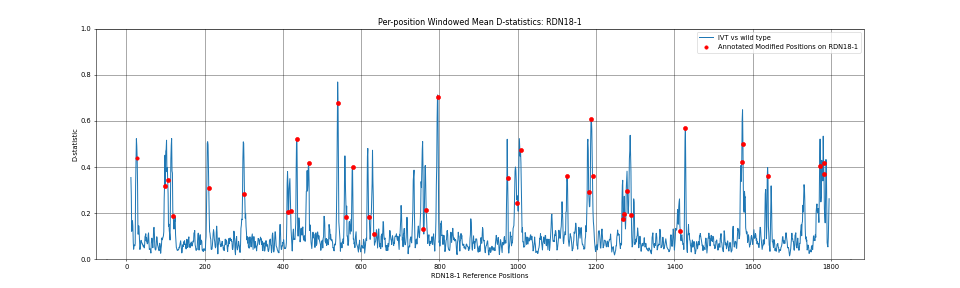

In [27]:
%matplotlib notebook
rrna_ref_name = "RDN18-1"
save_fig_path=f"figures/tombo/tombo_wt_vs_ivt_{rrna_ref_name}_plot.svg"
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


<IPython.core.display.Javascript object>


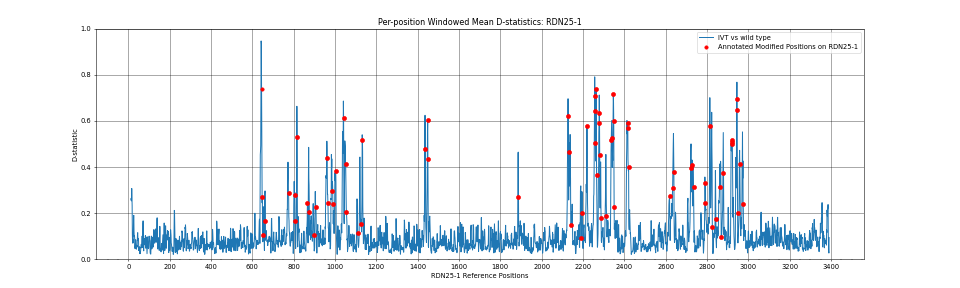

In [25]:
%matplotlib notebook
rrna_ref_name = "RDN25-1"
save_fig_path=f"figures/tombo/tombo_wt_vs_ivt_{rrna_ref_name}_plot.svg"
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


In [17]:
def plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=None, thresholds_at=None):
    tombo_data = {}
    label_data = {}
    probs = []

    column_names = ["unmod", "mod"]
    ts = tombo_stats.TomboStats(stats_file)
    for contig in ts:
        if contig[0] == rrna_ref_name and contig[1] == "+":
            all_data = contig[4]
            min_pos = all_data[0][1]
            max_pos = all_data[-1][1]
            for x in all_data:
                tombo_data[x[1]] = [x[0], 1-x[0]]
                label_data[x[1]] = [1, 0]
                probs.append(1-x[0])
    title = f"Tombo Distribution of 1 - D-statistic: {rrna_ref_name}"

    fig = plt.figure(figsize=(10, 8))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel("1 - D-statistic")
    panel1.set_ylabel("Counts")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
    panel1.set_title(label=title)
    panel1.hist(probs, label="IVT vs Native (NOP58_GAL)", bins=30)
    # panel1.axvline(x=np.mean(probs)-(2*(np.std(probs))), linewidth=5, color='g')
    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        label_data[pos] = [0, 1]
        if tombo_data[pos][0] > 0.75:
            print(pos, tombo_data[pos][0])
        if i == 0:
            panel1.axvline(x=tombo_data[pos][0], linewidth=1, color='r', label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.axvline(x=tombo_data[pos][0], linewidth=1, color='r')
    panel1.legend()

    # option to save figure or just show it
    if save_fig_paths is not None:
        plt.savefig(save_fig_paths[0])


    final_prob_data = []
    final_label_data = []                       
    for i in range(min_pos, max_pos+1):
        final_prob_data.append(tombo_data[i])
        final_label_data.append(label_data[i])     

    cm = ClassificationMetrics(pd.DataFrame(final_label_data, columns=column_names), 
                               pd.DataFrame(final_prob_data, columns=column_names), 
                               label_ids=list(range(min_pos, max_pos+1)))
    cm.plot_roc("mod", title=f"Tombo Reciever Operation Curve: {rrna_ref_name}", save_fig_path=save_fig_paths[1], thresholds_at=thresholds_at)

120 0.8124686185510863
414 0.795738728172628
420 0.792332485901572
562 0.8160787508276371
619 0.8157805549971435
632 0.8899105116083742
759 0.867118502398533
766 0.7882294395150039
999 0.7577550247747679
1269 0.8246497750200876
1271 0.8040711386954079
1290 0.806019489478523
1415 0.8759489940885805
650 0.8939646616886853
663 0.8330388051945631
807 0.8333990849563163
867 0.756007466557694
876 0.7952619675637663
898 0.8953338575107219
908 0.7737041554499027
966 0.7552104898409896
990 0.7599780274398884
1056 0.7953293118292226
1110 0.8854065622577331
1124 0.8472672606673939
2142 0.8533856670237725
2191 0.9087685491026081
2197 0.7994820524436678
2288 0.8212023607927751
2314 0.8124020724002124
2351 0.7734423584301094
2793 0.7548062035492099
2826 0.8614236265087319
2843 0.8256619602846138
2870 0.9022976810676827
2948 0.8004030750448349
2975 0.761643605218847


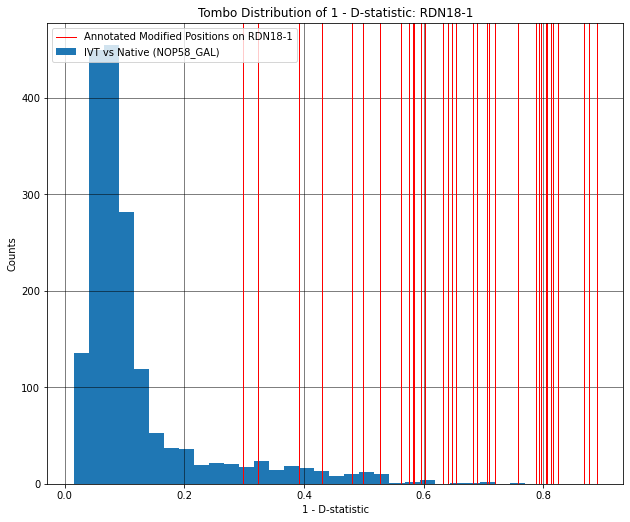

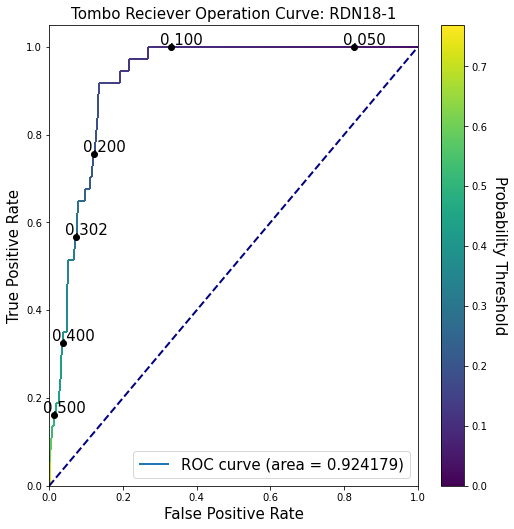

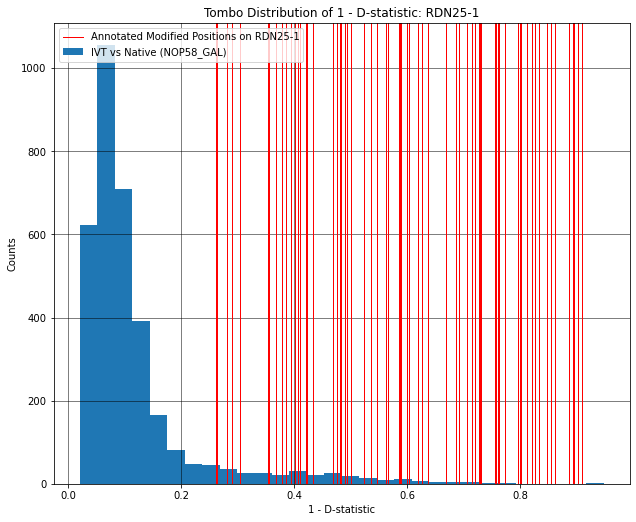

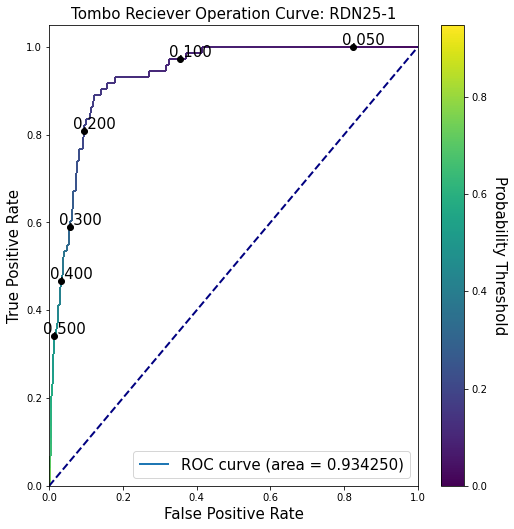

In [18]:
%matplotlib inline

rrna_ref_name = "RDN18-1"
stats_file = IVT_vs_WT_YPD
thresholds_at = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=[f"figures/tombo/tombo_ivt_wildtype_{rrna_ref_name}_dist.svg", f"figures/tombo/tombo_ivt_wildtype_{rrna_ref_name}_roc.svg"], thresholds_at=thresholds_at)
rrna_ref_name = "RDN25-1"
stats_file = IVT_vs_WT_YPD
thresholds_at = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=[f"figures/tombo/tombo_ivt_wildtype_{rrna_ref_name}_dist.svg", f"figures/tombo/tombo_ivt_wildtype_{rrna_ref_name}_roc.svg"], thresholds_at=thresholds_at)


In [19]:
def get_data_from_tombo(stats_file, contig_name, strand="+"):
    assert os.path.exists(stats_file)
    ts = tombo_stats.TomboStats(stats_file)
    for contig in ts:
        if contig[0] == contig_name and contig[1] == strand:
            all_data = contig[4]
            raw_data = [1-x[0] for x in all_data][10:]
            ref_positions = [x[1] for x in all_data][10:]
            return raw_data, ref_positions

def is_position_modified(position, peaks, properties, min_ref, delta=5):
    for l, r in zip(properties["left_ips"]+min_ref, properties["right_ips"]+min_ref):
        if l <= position <= r:
            return True

        
def get_peaks_accuracy(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=5):
    score = 0
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    mod_index = 0
    mods_per_peak = []
    mod_per_peak_widths = []
    n_mods = len(mods_data[contig_name])
    for l, r in zip(properties["left_ips"]+min_ref, properties["right_ips"]+min_ref):
        total_mods = 0
        all_mods_found = []
        keep_going = True
        while keep_going:
            pos = mods_data[contig_name][mod_index][0]
            if pos < l:
                fn += 1
                mod_index += 1
            elif r < pos:
                if total_mods == 0:
                    fp += 1
                keep_going = False
            else:
                tp += 1
                total_mods += 1
                mod_index += 1
                all_mods_found.append(pos)

            if mod_index == n_mods:
                mod_index -= 1
                keep_going = False

    #         print(l, r, pos, keep_going, tp, fp, tn, fn, score)
        score += get_score(total_mods)
        if total_mods > 1:
            delta = all_mods_found[-1] - all_mods_found[0]
        else:
            delta = 0
        mods_per_peak.append([total_mods, delta])
        mod_per_peak_widths.append([r-l])
    return tp, fp, tn, fn, score, mods_per_peak, mod_per_peak_widths

def plot_fit(reg, mods_per_peak, mod_per_peak_widths):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = [x[0] for x in mods_per_peak]
    ys = [x[1] for x in mods_per_peak]
    ax.scatter(xs=xs, ys=ys, zs=mod_per_peak_widths)
    z = reg.predict(X)
    ax.plot(xs=[x[0] for x in z], ys=[x[1] for x in z], zs=merge_lists(X))
    plt.show()

def get_score_and_regression(raw_data, 
                             ref_positions,
                             mods_data, 
                             contig_name,
                             function,
                             height=None, 
                             distance=None, 
                             threshold=None, 
                             width=None, 
                             prominence=None, 
                             wlen=None, 
                             rel_height=None,
                             delta=5):
    if distance is not None and distance < 1.0:
        distance = None
    if threshold is not None and threshold < 0.0:
        threshold = None
    if wlen is not None and wlen < 2:
        wlen = None
    peaks, properties = signal.find_peaks(raw_data, 
                                          height=height, 
                                          distance=distance, 
                                          threshold=threshold, 
                                          width=width, 
                                          prominence=prominence, 
                                          wlen=wlen, 
                                          rel_height=rel_height)
    min_ref = min(ref_positions)
    max_ref = max(ref_positions)
    if len(peaks) == 0:
        return None, -np.inf, 0, 0, get_true_negatives(mods_data[contig_name], min_ref, max_ref, delta=delta), len(mods_data[contig_name]), None, None, peaks, properties
    tp, fp, tn, fn, score, mods_per_peak, mod_per_peak_widths = function(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=delta)
    X, y = np.array(mod_per_peak_widths), np.array(mods_per_peak)
    reg = LinearRegression().fit(X, y)
#     print(reg.coef_)
#     print(reg.intercept_)
    reg_score = reg.score(X, y)
#     print(tp, fp, tn, fn, score, reg_score, sum(reg.coef_)[0]) 
#     if score > 15:
#         reg_score += sum(reg.coef_)[0]
    total_score = score + 30*(reg_score) - fn
    return reg, total_score, tp, fp, tn, fn, mods_per_peak, mod_per_peak_widths, peaks, properties

def is_position_modified2(position, peaks, properties, min_ref, delta=5):
    for peak in peaks:
        if (peak-delta+min_ref) <= position <= (peak+delta+min_ref):
            return True

        
def collect_close_peaks(peaks, properties, delta):
    if len(peaks) == 0:
        return peaks, properties
    new_peaks = []
    new_properties = []
    prev = peaks[0]
    curr_peaks = [peaks[0]]
    curr_properties = {"right_ips": [properties["right_ips"][0]], "left_ips": [properties["left_ips"][0]]}
    for i, peak in enumerate(peaks[1:]):
        if peak <= (prev + delta + delta - 1):
            curr_peaks.append(peak)
            curr_properties["right_ips"].append(properties["right_ips"][i+1])
            curr_properties["left_ips"].append(properties["left_ips"][i+1])
        else:
            new_peaks.append(curr_peaks)
            new_properties.append(curr_properties)
            curr_peaks = [peak]
            curr_properties = {"right_ips": [properties["right_ips"][i+1]], "left_ips": [properties["left_ips"][i+1]]}
        prev = peak
    new_peaks.append(curr_peaks)
    new_properties.append(curr_properties)
    return new_peaks, new_properties


def get_score2(n, n_peaks):
    ratio = n/n_peaks
    if ratio == 0:
        return -1
    elif ratio == 1:
        return 1*n_peaks
    else:
        return ratio
    

def get_possible_mod_pos(reference, peaks, base, delta=2):
    """Get possible modification positions"""
    mods = []
    for peak in peaks:
        if reference[peak] == base:
            mods.append([peak, [peak]])
        else:
            i = 1
            stop = False
            found = []
            while i <= delta and not stop:
                if reference[peak-i] == base:
                    found.append(peak-i)
                    stop = True
                if reference[peak+i] == base:
                    found.append(peak+i)
                    stop = True
                i += 1
            mods.append([peak, found])

    return mods

def get_negative_lables(min_ref, ref_seq):
#     create negative labels
    ref_pos = min_ref
    data = []
    for char in ref_seq:
        ref_pos += 1
        unmod = 1
        mod = 0
        data.append([ref_pos, "+", unmod, mod])
    all_contig_data = pd.DataFrame(data, columns=["ref_pos", "strand", "unmod", "mod"])
    all_contig_data = all_contig_data.set_index("ref_pos")
    return all_contig_data

def get_labelled_data(label_data, all_contig_data, delta = 5):
    #     get blocked out positions
    big_list = [list(range(x-delta+1, x))+list(range(x+1, x+delta)) for x in label_data["ref_pos"].values]
    drop_positions = []
    for x in label_data["ref_pos"].values:
        drop = list(range(x-delta+1, x))+list(range(x+1, x+delta))
        drop_positions.extend(drop)
        all_contig_data.loc[x, "Dstat"] = np.max(all_contig_data.loc[drop+[x]]["Dstat"])

    drop_positions = list((set(drop_positions) & set(all_contig_data.index)))
    all_labelled_data = all_contig_data.drop(drop_positions)
    all_labelled_data.loc[all_labelled_data.index.isin(label_data["ref_pos"]), "mod"] = 1
    all_labelled_data.loc[all_labelled_data.index.isin(label_data["ref_pos"]), "unmod"] = 0
    return all_labelled_data

In [20]:
def plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=None, thresholds_at=None, mods_data=mods_data, delta=5):
    raw_data, ref_positions = get_data_from_tombo(stats_file, rrna_ref_name)
    min_ref = ref_positions[0]
    max_ref = ref_positions[-1]+1
    ref_seq = rh.get_sequence(rrna_ref_name, min_ref, max_ref)
    contig_data = mods_data[rrna_ref_name]
    label_data = pd.DataFrame(contig_data, columns=["ref_pos", "strand", "ref-base", "variants"])
    all_contig_data = get_negative_lables(min_ref, ref_seq)
    all_contig_data["Dstat"] = 0
    for i, x in enumerate(raw_data):
        ref_pos = min_ref + i + 1
        all_contig_data.loc[ref_pos, "Dstat"] = x
    all_contig_data["1-Dstat"] = 1 - all_contig_data["Dstat"]
    all_labelled_data = get_labelled_data(label_data, all_contig_data, delta=delta)
    trim_start = 8
    cm = ClassificationMetrics(all_labelled_data[["unmod", "mod"]].iloc[trim_start:], 
                               all_labelled_data[["1-Dstat", "Dstat"]].iloc[trim_start:].rename(columns={"Dstat": "mod", "1-Dstat": "unmod"}), 
                               label_ids=all_labelled_data.iloc[trim_start:].index.values)
    cm.plot_roc("mod", title=f"Tombo Reciever Operation Curve: {rrna_ref_name}", save_fig_path=save_fig_path, thresholds_at=thresholds_at)

In [21]:
delta = 2

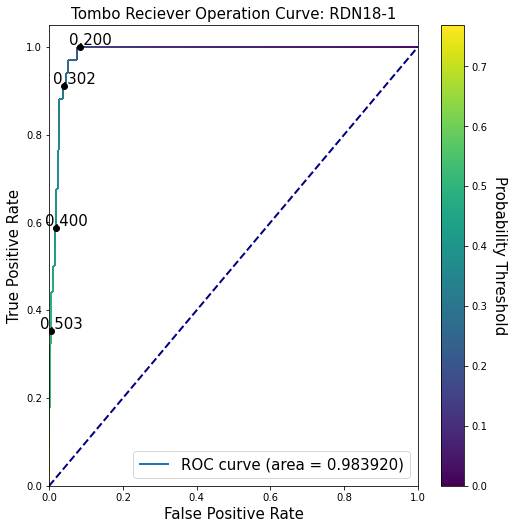

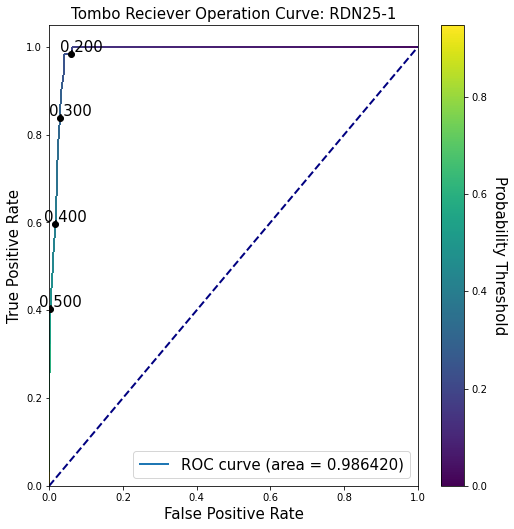

In [24]:
rrna_ref_name = "RDN18-1"
stats_file = IVT_vs_WT_YPD
save_fig_path=f"figures/tombo/tombo_ivt_wildtype_{rrna_ref_name}_delta_roc.svg"
thresholds_at = [0.5000, 0.40000, 0.30000, 0.20000]
plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)
rrna_ref_name = "RDN25-1"
save_fig_path=f"figures/tombo/tombo_ivt_wildtype_{rrna_ref_name}_delta_roc.png"
plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)